# Encoder model Testing Results

In [12]:
%load_ext autoreload
%autoreload

import sys
import torch
import torch.nn as nn

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import encoder as e
import Classifier as Classifier
import Baseline_classifiers as bc
from bertviz import model_view, head_view

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [14]:
class PositionalEncoding(e.PositionalEncoding):
    pass

class EncoderClassifier(e.EncoderClassifier):
    pass

## Choose organism

In [4]:
organism = "E.Coli"
e.set_organism(organism)

Länge train_dataset: 3555
Länge valid_dataset: 420
Länge test df: 386


## Result Visualization

In [19]:
true_codons, pred_codons_replaced = e.eval_best_model()

# Remove Padding
predictions = []
for codon_seq in pred_codons_replaced:
    predictions.append([codon for codon in codon_seq if codon != ''])

# Flatten    
predicted, labels = mle.flatten_for_plotting(predictions, true_codons, filter_pads=False)

# Translate to integers
predicted_int = []
for codon in predicted:
    predicted_int.append(mlh.codons_to_integer[codon])

labels_int = []
for codon in labels:
    labels_int.append(mlh.codons_to_integer[codon])

predicted_aa =  mle.translate_codons(predicted)
labels_aa =  mle.translate_codons(labels)

Model loaded: 20240625154331_encoder_64em_2l_4h_05dr_200ep.pt
Model used max bias codon for 89.52% of possible codon predictions
Replaced 0.00% of codons


### Index-based Segment Accuracy

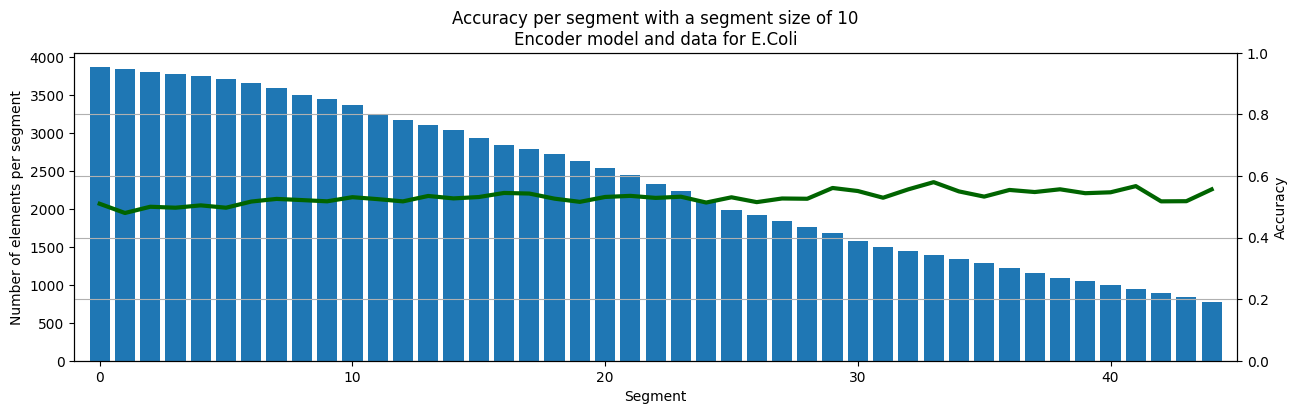

In [13]:
segment_size = 10

preds = []
for codon_seq in pred_codons_replaced:
    preds.append(list(codon_seq[codon_seq != '']))

classifier = Classifier.Classifier()
seg_acc, seg_el = classifier.calc_accuracy_per_segment(list(true_codons), preds, segment_size=segment_size, cut_data_at=0.2)
mle.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy per segment with a segment size of {segment_size}\nEncoder model and data for {organism}")

### Confusion Matrix (Codons)

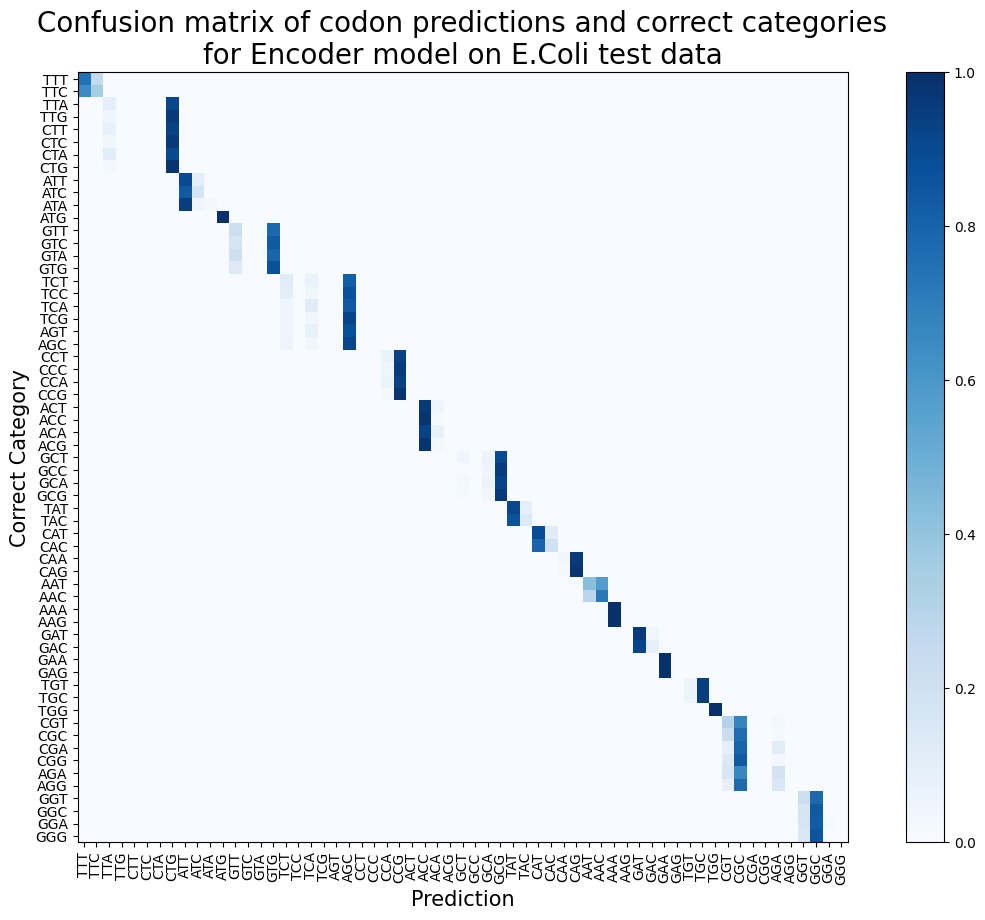

In [21]:
title = f'Confusion matrix of codon predictions and correct categories\nfor Encoder model on {organism} test data'

plt = mle.plot_confusion_matrix(labels_int, predicted_int, mlh.codons, title, sort_codons=True)
plt.show()

### Confusion Matrix (Amino acids)

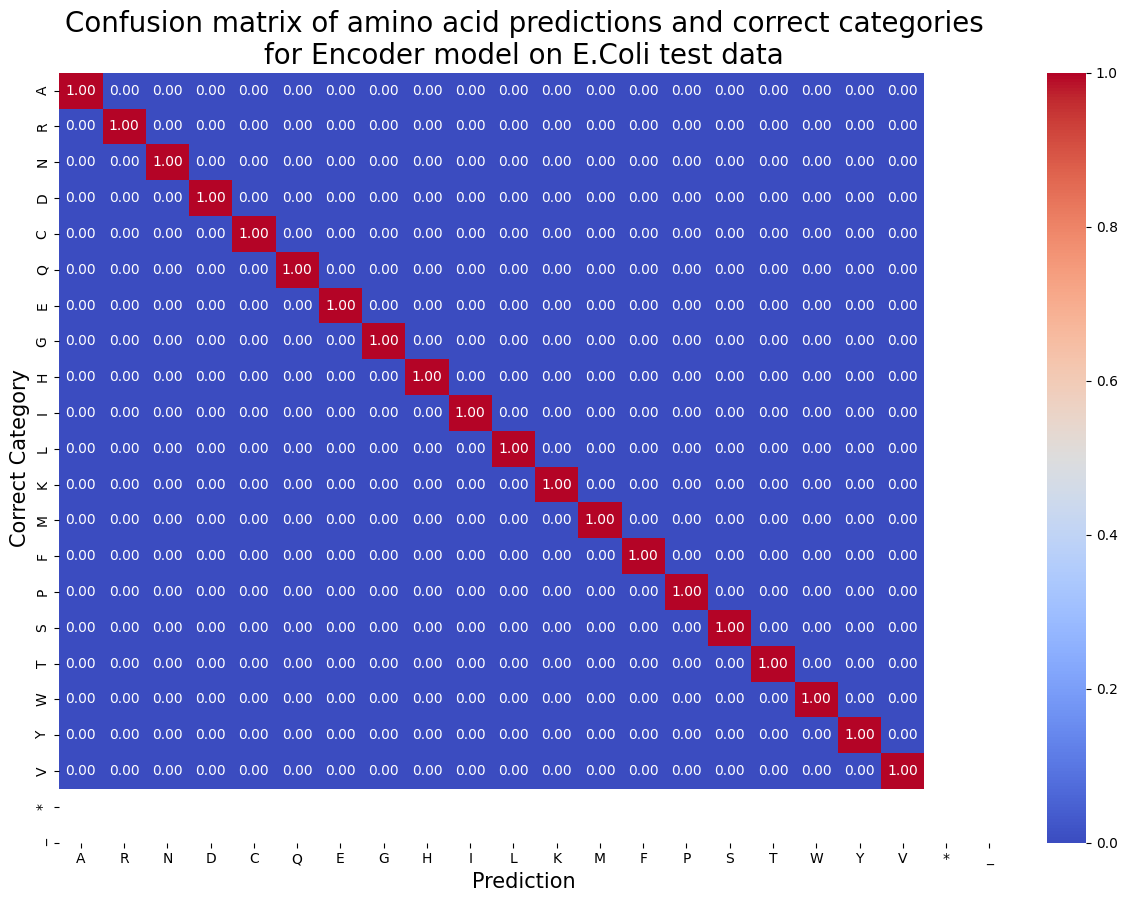

In [23]:
plt = mle.plot_confusion_matrix_sns(labels_aa, predicted_aa, mlh.amino_acids, 
                                        f'Confusion matrix of amino acid predictions and correct categories\nfor Encoder model on {organism} test data')
plt.show()

### Codon Usage Bias

In [24]:
usage_biases_codons = {}
codon_to_aa = mle.dict_aa_codon()
for codon in labels:
    aa = codon_to_aa[codon]
    usage_biases_codons[codon] = e.usage_biases[aa][codon]

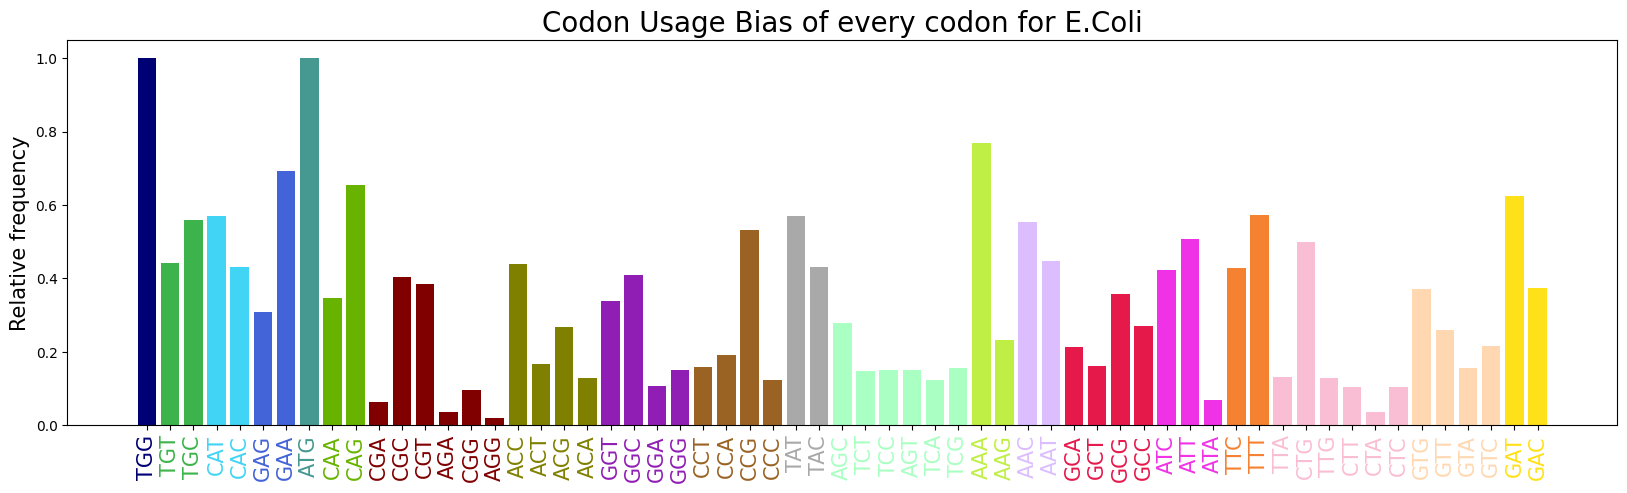

In [28]:
_, _ = mle.plot_cub(usage_biases_codons, f"Codon Usage Bias of every codon for {organism}")

### Accuracy per Codon

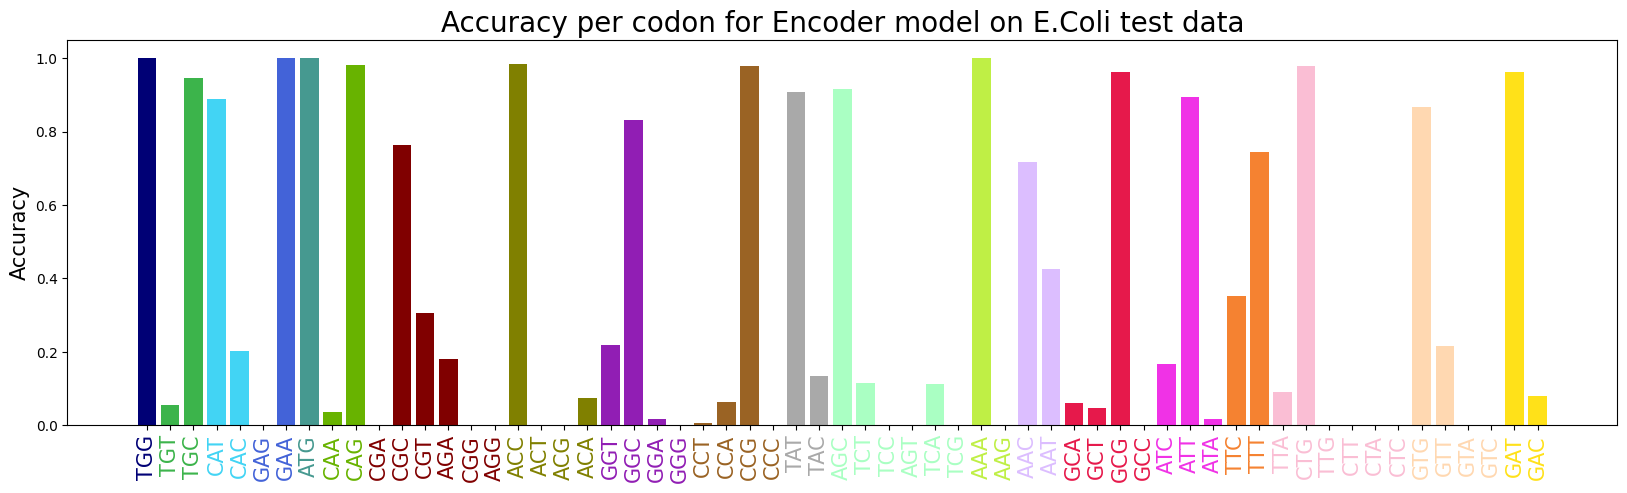

In [33]:
plt = mle.plot_codon_acc(labels_int, predicted_int, f'Accuracy per codon for Encoder model on {organism} test data')

### Relative Prediction Frequency per Codon

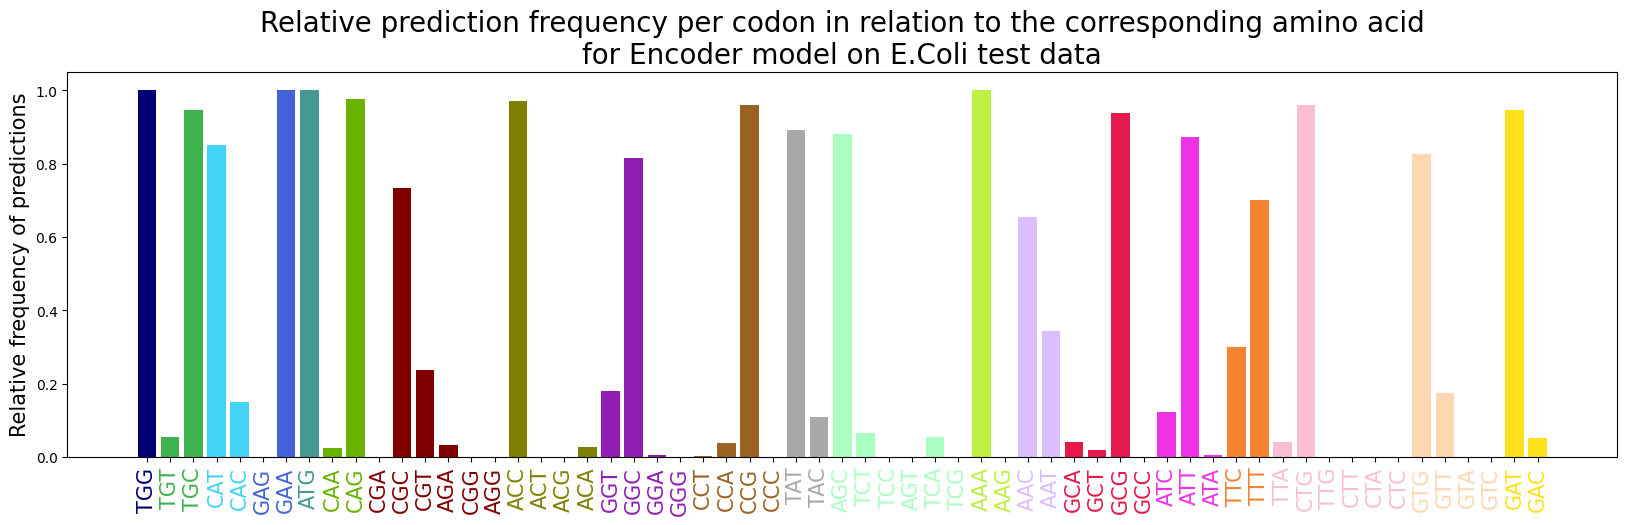

In [34]:
codon_counted_predicted = mle.codon_count(predicted_int, labels)
plt = mle.plot_relative_codon_count(codon_counted_predicted, predicted_int, f'Relative prediction frequency per codon in relation to the corresponding amino acid\nfor Encoder model on {organism} test data')

### Comparison Max CUB with Model Diagrams

In [36]:
pn_dict = mle.create_pn_dict(predicted, labels, organism)
cub_test_data = {}

for codon in pn_dict:
    aa = mlh.codon_to_amino_acid[codon]
    aa_codons = mlh.amino_acids_to_codons.get(aa, [])
    aa_sum = sum(pn_dict[c]['num'] for c in aa_codons)
    cub_test_data[codon] = pn_dict[codon]['num'] / aa_sum


<module 'matplotlib.pyplot' from '/home/mkuehn/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

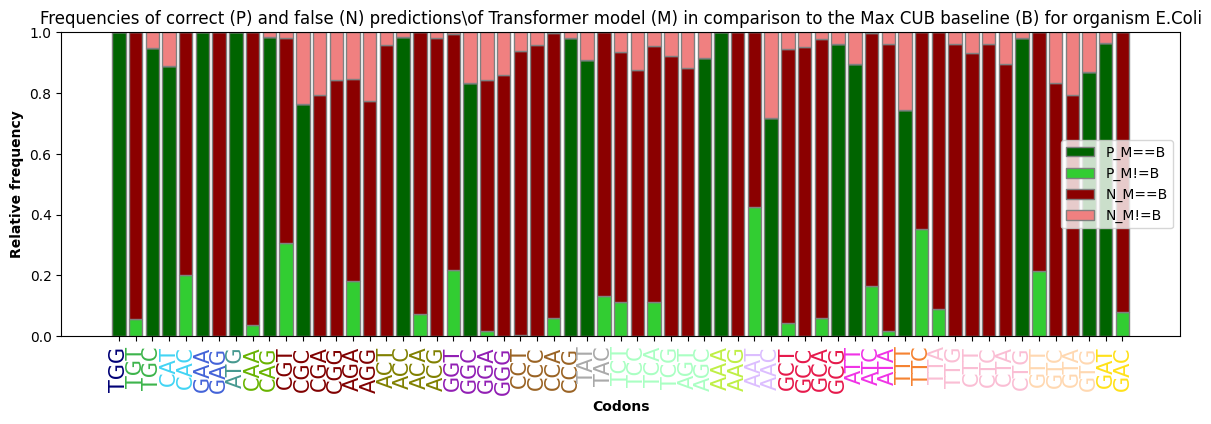

In [43]:
mle.plot_pn_dict(pn_dict, 'Transformer', organism)

# Explainable AI Approaches

## Embedding Visualization

In [60]:
model = mlh.load_model('encoder', organism, device=device)

Model loaded: 20240625154331_encoder_64em_2l_4h_05dr_200ep.pt


In [66]:
amino_acids_int = torch.tensor([mlh.aminoacids_to_integer[aa] for aa in mlh.amino_acids]).to(device)
amino_acids_int

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21], device='cuda:1')

In [61]:
class Embedder(nn.Module):
    def __init__(self, model_with_weights: EncoderClassifier):
        super(Embedder, self).__init__()
        self.emb = nn.Embedding.from_pretrained(model_with_weights.emb.weight)

    def forward(self, x):
        return self.emb(x)

In [62]:
embedder = Embedder(model).to(device)
embedder

Embedder(
  (emb): Embedding(22, 64)
)

In [68]:
embedding = embedder(amino_acids_int).cpu().detach().numpy()
print("shape", embedding.shape)
print(embedding)

shape (22, 64)
[[ 1.9020721   1.4628955   0.835563   ...  1.8585458  -1.2230741
   1.309687  ]
 [ 1.4915341   0.8536411   2.206738   ...  0.21653803  0.6943017
   0.38645336]
 [ 1.8739142   0.89029014 -1.500881   ... -0.5250142   0.7154268
   0.7266078 ]
 ...
 [-0.07712561  1.0774609   1.422537   ... -0.14857478 -0.68891823
  -1.3430759 ]
 [-0.29485354 -0.27986267  1.0837125  ...  2.0561688  -0.2347232
  -1.3456243 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [71]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [72]:
writer = SummaryWriter()
writer.add_embedding(embedding, mlh.amino_acids)
writer.flush()

#### Start tensor board with
```zsh
tensorboard --logdir=notebooks/runs
```
adjust path if needed

In [74]:
#%tensorboard --logdir runs

## Attention Weight Visualization

In [44]:
model = mlh.load_model('encoder', organism, device=device)

Model loaded: 20240625154331_encoder_64em_2l_4h_05dr_200ep.pt


In [46]:
tokens, labels = next(iter(e.valid_loader))
first_row = tokens[0]
first_row_batched = first_row.unsqueeze(0)
print(first_row_batched.shape)

torch.Size([1, 500])


In [47]:
output, attn_weights = model(first_row_batched, attn_weights_needed=True)

In [55]:
sliced_attn_weights = []
slice_size = 30
for attn_weight in attn_weights:
    sliced_attn_weight = attn_weight[:, :, :slice_size, :slice_size]
    sliced_attn_weights.append(sliced_attn_weight)

In [56]:
first_row_sliced = [mlh.integer_to_aminoacids[token.item()] for token in first_row[:slice_size]]

In [57]:
model_view(sliced_attn_weights, first_row_sliced)

<IPython.core.display.Javascript object>

In [58]:
head_view(sliced_attn_weights, first_row_sliced)

<IPython.core.display.Javascript object>

# Accuracy Results on Testing Data (Hyperparameter Analysis + Shuffled Data)

## E.Coli

In [9]:
%autoreload

In [15]:
organism = "E.Coli"
e.set_organism(organism)

Länge train_dataset: 3555
Länge valid_dataset: 420
Länge test df: 386


### Best Model Accuracy

In [16]:
embed_dim = 64
num_encoder_layers = 2
num_heads = 4
dropout = 0.5
pos_enc = False
e.eval_parameter_model(embed_dim, num_encoder_layers, num_heads, dropout, pos_enc)

Model loaded: 20240627091800_encoder_64em_2l_4h_05dr_400ep.pt
Model used max bias codon for 89.52% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.527 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 2 layers, 4 heads
Took 4.76 seconds



0.527

### Hyperparameter Results

In [69]:
accuracies = {}

#### Dropout

In [70]:
EMBED_DIM = [256]
NUM_ENCODER_LAYERS = [4]
NUM_HEADS = [4]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
POS_ENC = [False]
accuracies = e.eval_hyperparameter_training(accuracies, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, dropouts, POS_ENC)

['20240603144534_encoder_64em_8l_4h_05dr_12ep.pt', '20240603142405_encoder_256em_4l_4h_01dr_16ep.pt', '20240603142704_encoder_256em_4l_4h_04dr_16ep.pt', '20240603142505_encoder_256em_4l_4h_02dr_16ep.pt', '20240603143309_encoder_128em_4l_4h_05dr_8ep.pt', '20240603142803_encoder_256em_4l_4h_05dr_16ep.pt', '20240603144358_encoder_64em_8l_1h_05dr_20ep.pt', '20240603143851_encoder_64em_2l_1h_05dr_21ep.pt', '20240603143903_encoder_64em_2l_2h_05dr_12ep.pt', '20240603144728_encoder_64em_8l_8h_05dr_20ep.pt', '20240603143816_encoder_64em_1l_2h_05dr_8ep.pt', '20240603144442_encoder_64em_8l_2h_05dr_12ep.pt', '20240603142604_encoder_256em_4l_4h_03dr_16ep.pt', '20240603143811_encoder_64em_1l_1h_05dr_8ep.pt', '20240603145400_encoder_64em_2l_4h_posenc_05dr_13ep.pt', '20240603144101_encoder_64em_4l_2h_05dr_19ep.pt', '20240603144025_encoder_64em_4l_1h_05dr_20ep.pt', '20240603143558_encoder_512em_4l_4h_05dr_16ep.pt', '20240603143951_encoder_64em_2l_8h_05dr_16ep.pt', '20240603143821_encoder_64em_1l_4h_05d

#### Embedding Dimension

In [38]:
embed_dims = [16, 32, 64, 128, 256, 512]
NUM_ENCODER_LAYERS = [4]
NUM_HEADS = [4]
DROPOUTS = [0.5]
POS_ENC = [False]
accuracies = e.eval_hyperparameter_training(accuracies, embed_dims, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUTS, POS_ENC)

Model loaded: 20240603143100_encoder_16em_4l_4h_05dr_18ep.pt
Model used max bias codon for 94.67% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5196 - Organism: E.Coli, Encoder Model - Parameters: 16 embedding dim, 4 layers, 4 heads
Took 4.73 seconds

Model loaded: 20240603143205_encoder_32em_4l_4h_05dr_31ep.pt
Model used max bias codon for 97.43% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5228 - Organism: E.Coli, Encoder Model - Parameters: 32 embedding dim, 4 layers, 4 heads
Took 4.67 seconds

Model loaded: 20240603143249_encoder_64em_4l_4h_05dr_20ep.pt
Model used max bias codon for 94.01% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5262 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 4.74 seconds

Model loaded: 20240603143309_encoder_128em_4l_4h_05dr_8ep.pt
Model used max bias codon for 95.48% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5227 - Organism:

#### Number Encoder Layers and Heads

In [39]:
EMBED_DIM = [64]
num_encoder_layers = [1, 2, 4, 8]
num_heads = [1, 2, 4, 8]
DROPOUTS = [0.5]
POS_ENC = [False]
accuracies = e.eval_hyperparameter_training(accuracies, EMBED_DIM, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

/home/mkuehn/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model loaded: 20240603143811_encoder_64em_1l_1h_05dr_8ep.pt
Model used max bias codon for 99.54% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5186 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 1 layers, 1 heads
Took 4.59 seconds

Model loaded: 20240603143816_encoder_64em_1l_2h_05dr_8ep.pt
Model used max bias codon for 99.36% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.519 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 1 layers, 2 heads
Took 4.6 seconds

Model loaded: 20240603143821_encoder_64em_1l_4h_05dr_8ep.pt
Model used max bias codon for 99.33% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5198 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 1 layers, 4 heads
Took 4.6 seconds

Model loaded: 20240603143832_encoder_64em_1l_8h_05dr_15ep.pt
Model used max bias codon for 94.08% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5226 - Organism: E.Col

#### Positional Encoding

In [47]:
EMBED_DIM = [64]
NUM_ENCODER_LAYERS = [2]
NUM_HEADS = [4]
DROPOUTS = [0.5]
pos_enc = [True, False]
accuracies = e.eval_hyperparameter_training(accuracies, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUTS, pos_enc)

Model loaded: 20240603145400_encoder_64em_2l_4h_05dr_posenc_13ep.pt
Model used max bias codon for 97.97% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5194 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 2 layers, 4 heads
Took 4.68 seconds

------
{'encoder_256em_4l_4h_01dr': 0.521, 'encoder_256em_4l_4h_02dr': 0.5205, 'encoder_256em_4l_4h_03dr': 0.5207, 'encoder_256em_4l_4h_04dr': 0.5212, 'encoder_256em_4l_4h_05dr': 0.5215, 'encoder_16em_4l_4h_05dr': 0.5196, 'encoder_32em_4l_4h_05dr': 0.5228, 'encoder_64em_4l_4h_05dr': 0.5262, 'encoder_128em_4l_4h_05dr': 0.5227, 'encoder_512em_4l_4h_05dr': 0.5099, 'encoder_64em_1l_1h_05dr': 0.5186, 'encoder_64em_1l_2h_05dr': 0.519, 'encoder_64em_1l_4h_05dr': 0.5198, 'encoder_64em_1l_8h_05dr': 0.5226, 'encoder_64em_2l_1h_05dr': 0.5263, 'encoder_64em_2l_2h_05dr': 0.5241, 'encoder_64em_2l_4h_05dr': 0.5264, 'encoder_64em_2l_8h_05dr': 0.5258, 'encoder_64em_4l_1h_05dr': 0.5258, 'encoder_64em_4l_2h_05dr': 0.5253, 'encode

#### Save E.Coli accuracies

In [48]:
mlh.to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [49]:
accuracies = mlh.from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [50]:
accuracies

{'encoder_256em_4l_4h_01dr': 0.521,
 'encoder_256em_4l_4h_02dr': 0.5205,
 'encoder_256em_4l_4h_03dr': 0.5207,
 'encoder_256em_4l_4h_04dr': 0.5212,
 'encoder_256em_4l_4h_05dr': 0.5215,
 'encoder_16em_4l_4h_05dr': 0.5196,
 'encoder_32em_4l_4h_05dr': 0.5228,
 'encoder_64em_4l_4h_05dr': 0.5262,
 'encoder_128em_4l_4h_05dr': 0.5227,
 'encoder_512em_4l_4h_05dr': 0.5099,
 'encoder_64em_1l_1h_05dr': 0.5186,
 'encoder_64em_1l_2h_05dr': 0.519,
 'encoder_64em_1l_4h_05dr': 0.5198,
 'encoder_64em_1l_8h_05dr': 0.5226,
 'encoder_64em_2l_1h_05dr': 0.5263,
 'encoder_64em_2l_2h_05dr': 0.5241,
 'encoder_64em_2l_4h_05dr': 0.5264,
 'encoder_64em_2l_8h_05dr': 0.5258,
 'encoder_64em_4l_1h_05dr': 0.5258,
 'encoder_64em_4l_2h_05dr': 0.5253,
 'encoder_64em_4l_8h_05dr': 0.5251,
 'encoder_64em_8l_1h_05dr': 0.5252,
 'encoder_64em_8l_2h_05dr': 0.5235,
 'encoder_64em_8l_4h_05dr': 0.523,
 'encoder_64em_8l_8h_05dr': 0.5253,
 'encoder_64em_2l_4h_05dr_posenc': 0.5194}

--> Best suited parameters: encoder_64em_2l_4h_05dr - Accuracy: 0.5264

### Shuffled Data

In [17]:
organism = "E.Coli"
e.load_shuffled_data()

In [18]:
EMBED_DIM = 64
NUM_ENCODER_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.5
POS_ENC = False
e.eval_parameter_model(EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUT, POS_ENC)

Model loaded: 20240627091800_encoder_64em_2l_4h_05dr_400ep.pt


Model used max bias codon for 89.54% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5265 - Organism: E.Coli, Encoder Model - Parameters: 64 embedding dim, 2 layers, 4 heads
Took 4.77 seconds



0.5265

## Drosophila.Melanogaster

In [19]:
organism = "Drosophila.Melanogaster"
e.set_organism(organism)

Länge train_dataset: 33040
Länge valid_dataset: 4073
Länge test df: 2168


### Best Model Accuracy

In [20]:
embed_dim = 64
num_encoder_layers = 4
num_heads = 4
dropout = 0.2
pos_enc = True
e.eval_parameter_model(embed_dim, num_encoder_layers, num_heads, dropout, pos_enc)

Model loaded: 20240626115352_encoder_64em_4l_4h_posenc_02dr_400ep.pt
Model used max bias codon for 76.05% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5296 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 59.84 seconds



0.5296

### Hyperparameter Results

In [55]:
accuracies = {}

In [56]:
embed_dims = [64, 128]
num_encoder_layers = [2, 4]
num_heads = [2, 4]
DROPOUTS = [0.2, 0.5]
POS_ENC = [False]
accuracies = e.eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240603150541_encoder_64em_2l_2h_02dr_10ep.pt
Model used max bias codon for 56.96% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4986 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 2 layers, 2 heads
Took 56.4 seconds

Model loaded: 20240603150712_encoder_64em_2l_2h_05dr_10ep.pt
Model used max bias codon for 57.40% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4981 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 2 layers, 2 heads
Took 56.68 seconds

Model loaded: 20240603150858_encoder_64em_2l_4h_02dr_10ep.pt
Model used max bias codon for 56.39% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4986 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 2 layers, 4 heads
Took 56.66 seconds

Model loaded: 20240603151045_encoder_64em_2l_4h_05dr_10ep.pt
Model used max bias codon for 56.84% of possible codon predictions


In [69]:
# Test best model, trained for longer
embed_dims = [64]
num_encoder_layers = [4]
num_heads = [4]
DROPOUTS = [0.2]
POS_ENC = [False, True]
accuracies = e.eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240603163741_encoder_64em_4l_4h_posenc_02dr_50ep.pt
Model used max bias codon for 78.75% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5101 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 57.55 seconds

------
{'encoder_64em_2l_2h_02dr': 0.4986, 'encoder_64em_2l_2h_05dr': 0.4981, 'encoder_64em_2l_4h_02dr': 0.4986, 'encoder_64em_2l_4h_05dr': 0.4982, 'encoder_64em_4l_2h_02dr': 0.4982, 'encoder_64em_4l_2h_05dr': 0.4982, 'encoder_64em_4l_4h_02dr': 0.4988, 'encoder_64em_4l_4h_05dr': 0.4982, 'encoder_128em_2l_2h_02dr': 0.4983, 'encoder_128em_2l_2h_05dr': 0.4986, 'encoder_128em_2l_4h_02dr': 0.4987, 'encoder_128em_2l_4h_05dr': 0.4983, 'encoder_128em_4l_2h_02dr': 0.4981, 'encoder_128em_4l_2h_05dr': 0.4979, 'encoder_128em_4l_4h_02dr': 0.4982, 'encoder_128em_4l_4h_05dr': 0.4978, 'encoder_64em_4l_4h_posenc_02dr': 0.5101}
------
('encoder_64em_4l_4h_posenc_02dr', 0.5101)


#### Save Drosophila.Melanogaster accuracies

In [70]:
mlh.to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [71]:
accuracies = mlh.from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [74]:
accuracies

{'encoder_64em_2l_2h_02dr': 0.4986,
 'encoder_64em_2l_2h_05dr': 0.4981,
 'encoder_64em_2l_4h_02dr': 0.4986,
 'encoder_64em_2l_4h_05dr': 0.4982,
 'encoder_64em_4l_2h_02dr': 0.4982,
 'encoder_64em_4l_2h_05dr': 0.4982,
 'encoder_64em_4l_4h_02dr': 0.4988,
 'encoder_64em_4l_4h_05dr': 0.4982,
 'encoder_128em_2l_2h_02dr': 0.4983,
 'encoder_128em_2l_2h_05dr': 0.4986,
 'encoder_128em_2l_4h_02dr': 0.4987,
 'encoder_128em_2l_4h_05dr': 0.4983,
 'encoder_128em_4l_2h_02dr': 0.4981,
 'encoder_128em_4l_2h_05dr': 0.4979,
 'encoder_128em_4l_4h_02dr': 0.4982,
 'encoder_128em_4l_4h_05dr': 0.4978,
 'encoder_64em_4l_4h_posenc_02dr': 0.5101}

--> Best suited parameters: encoder_64em_4l_4h_posenc_02dr - Accuracy: 0.5101

### Shuffled Data

In [21]:
organism = "Drosophila.Melanogaster"
e.load_shuffled_data()

In [22]:
EMBED_DIM = 64
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 4
DROPOUT = 0.2
POS_ENC = True
e.eval_parameter_model(EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUT, POS_ENC)

Model loaded: 20240626115352_encoder_64em_4l_4h_posenc_02dr_400ep.pt
Model used max bias codon for 80.07% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4821 - Organism: Drosophila.Melanogaster, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 59.71 seconds



0.4821

## Homo.Sapiens

In [23]:
organism = "Homo.Sapiens"
e.set_organism(organism)

Länge train_dataset: 140711
Länge valid_dataset: 17784
Länge test df: 9139


### Best Model Accuracy

In [24]:
embed_dim = 64
num_encoder_layers = 4
num_heads = 4
dropout = 0.2
pos_enc = True
e.eval_parameter_model(embed_dim, num_encoder_layers, num_heads, dropout, pos_enc)

Model loaded: 20240627021811_encoder_64em_4l_4h_posenc_02dr_400ep.pt
Model used max bias codon for 53.61% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5356 - Organism: Homo.Sapiens, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 294.23 seconds



0.5356

### Hyperparameter Results

In [76]:
accuracies = {}

In [77]:
embed_dims = [64]
num_encoder_layers = [4]
num_heads = [4]
DROPOUTS = [0.2]
POS_ENC = [False, True]
accuracies = e.eval_hyperparameter_training(accuracies, embed_dims, num_encoder_layers, num_heads, DROPOUTS, POS_ENC)

Model loaded: 20240603182243_encoder_64em_4l_4h_02dr_55ep.pt
Model used max bias codon for 54.50% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5106 - Organism: Homo.Sapiens, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 282.53 seconds

Model loaded: 20240603201950_encoder_64em_4l_4h_posenc_02dr_80ep.pt
Model used max bias codon for 50.25% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.5232 - Organism: Homo.Sapiens, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 284.51 seconds

------
{'encoder_64em_4l_4h_02dr': 0.5106, 'encoder_64em_4l_4h_posenc_02dr': 0.5232}
------
('encoder_64em_4l_4h_posenc_02dr', 0.5232)


#### Save Homo.Sapiens accuracies

In [78]:
mlh.to_pickle(accuracies, f"../data/{organism}/encoder_accuracies.pkl")

In [79]:
accuracies = mlh.from_pickle(f"../data/{organism}/encoder_accuracies.pkl")

In [80]:
accuracies

{'encoder_64em_4l_4h_02dr': 0.5106, 'encoder_64em_4l_4h_posenc_02dr': 0.5232}

--> Best suited parameters: encoder_64em_4l_4h_posenc_02dr - Accuracy: 0.5232

### Shuffled Data

In [25]:
organism = "Homo.Sapiens"
e.load_shuffled_data()

In [26]:
EMBED_DIM = 64
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 4
DROPOUT = 0.2
POS_ENC = True
e.eval_parameter_model(EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, DROPOUT, POS_ENC)

Model loaded: 20240627021811_encoder_64em_4l_4h_posenc_02dr_400ep.pt
Model used max bias codon for 56.65% of possible codon predictions
Replaced 0.00% of codons
Accuracy: 0.4696 - Organism: Homo.Sapiens, Encoder Model - Parameters: 64 embedding dim, 4 layers, 4 heads
Took 294.73 seconds



0.4696